In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0117 Dissertation

- Supervisor: Prof. Josep Grau-Bove
- Candidate: BNWF8
- [Database Directory](https://drive.google.com/drive/folders/1YoR_6sK0GxmpRQZZURBTNu3T7ClDk3Dg?usp=sharing), including two segment plans. This notebook examplies the "integrated_segment" plan which is the final plan for my dissertation.
  - Node info CSV
  - Edge info CSV
  - Results
    - ALL intrinsic and extrinsic metric values for each segment of Chaozong
    - DepthmapX file (Space Syntax Graph file, read by [DepthmapX](https://github.com/SpaceGroupUCL/depthmapX/releases))
- Other data:
  - [the store survey of Chaozong](https://docs.google.com/spreadsheets/d/1GuUdx-x8SPNiN8LtoLlw02ac-wweSxW_/edit?usp=drive_link&ouid=103562281592361406546&rtpof=true&sd=true) provided by Hunan University
- Intro: This notebook is comprised of two parts
  - Calculation of Entropy Segment Integration (ESIN) and Entropy Segment Choice (ESCH)
  - GLM model fitting

## 1 - Calculate intrinsic and extrinsic values
Two csv files are for constructing network, one is for nodes, another is for edges. Please download and update the directories while reading csv files.

1.   [node csv](https://drive.google.com/file/d/1eDdWulHMgJHJdwwJGmA1UwpxzUQpHkyy/view?usp=share_link)
2.   [edge csv](https://drive.google.com/file/d/1FNtPy-K6zlVcM6WyUsAp7eAedh31CQ9X/view?usp=share_link)



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# import node and edge info
# please download files per the directories
# integrated segment plan
node_df = pd.read_csv('/content/drive/MyDrive/BNWF8/integrated_segment/network_construction/Node_integrated.csv')
edge_df = pd.read_csv('/content/drive/MyDrive/BNWF8/integrated_segment/network_construction/Edge_integrated.csv')

# fragmented segment plan
# node_df = pd.read_csv('/content/drive/MyDrive/BNWF8/fragmented_segment/network_construction/Node_fragmented.csv')
# edge_df = pd.read_csv('/content/drive/MyDrive/BNWF8/fragmented_segment/network_construction/Edge_fragmented.csv')

**node csv columns introduction:**

1.   Ref: the segment ID for constructing maps in DepthmapX
2.   x1, x2, y1, y2: the coordinates of the two endings of segments
3.   nodes: the names of segments
4.   check_in: the number of check-ins for each segment
5.   1_1 to 4_3: the category code for Facades and Fronts, where the first digit stands for the style types (1: Non-historic, 2: Abstract-historic, 3: Fake-historic, 4:True-historic), and the second digit represents the visual quality (1: Low, 2: Medium, 3: High), e.g. 2_3 means Abstract-historic & High visual quality
6.   constitutedness: a space syntax metric to evaluate the degree of safety
7.   choice: space syntax metric to measure the betweenness centrality of a segment
8.   integration: space syntax metric to measure the closeness centrality of a segment
9.   NACH: space syntax angular-weighted metric to measure the angular betweenness centrality of a segment
10.   NACH: space syntax angular-weighted metric to measure the angular closeness centrality of a segment

**edge csv columns introduction:**

1.   from: the starting node
2.   to: the destination node

however the graph is undirected!

### 1.1 Define types of entropy based on speculations of tourists' preferences of Facades and Fronts (FF)

In [ ]:
# define entropy types
type_dict = {
            'total':['4_3','4_2','4_1','3_3','3_2','3_1','2_3','2_2','2_1','1_3','1_2','1_1']
            ,'high_quality':['4_3','3_3','2_3','1_3']
            ,'above_low_quality':['4_3','4_2','3_3','3_2','2_3','2_2','1_3','1_2']
            ,'true_hist':['4_3','4_2','4_1']
            ,'true_hist_abvlow':['4_3','4_2']
            ,'fake_hist':['3_3','3_2','3_1']
            ,'fake_hist_abvlow':['3_3','3_2']
            ,'abstract_hist':['2_3','2_2','2_1']
            ,'abstract_hist_abvlow':['2_3','2_2']
            ,'non_hist':['1_3','1_2','1_1']
            ,'non_hist_abvlow':['1_3','1_2']
              }

type_list = ['total','high_quality','above_low_quality',
             'true_hist','fake_hist','abstract_hist','non_hist','true_hist_abvlow',
             'fake_hist_abvlow', 'abstract_hist_abvlow','non_hist_abvlow']


### 1.2 Calculate Intrinsic Metric Values



1.   Count the number of FFs per the types, let's say $n$
2.   Using simplified Shannon Information Entropy formula to calculate the entropy value: $H(X) = \log_2 n$
3.   In case of $n=0$ (no FFs in a segment) which leads to error in logrithm computation, 1 is added to $n$ - $H(X) = \log_2 (n + 1)$





In [ ]:
# function of calculating intrinsic metric values (segment entropies) for nodes
import math
def calc_entropy(entropy_type, dataframe):
  dataframe['info_num'] = dataframe[type_dict[entropy_type]].sum(axis=1)  # acquire the total amounts per the types defined
  dataframe['info_num'] = dataframe['info_num'] + 1  # add 1 to avoid the logorithm calculation error
  entropy_nm = entropy_type + '_ep'
  dataframe[entropy_nm] =  dataframe['info_num'].apply(lambda x: math.log(x,2))
  return dataframe

# iterate the types for calculating intrinsic metric values
for type in type_list:
  node_df = calc_entropy(type, node_df)

<ipython-input-111-80c87b212f6c>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataframe['info_num'] = dataframe[type_dict[entropy_type]].sum(axis=1)  # acquire the total amounts per the types defined
<ipython-input-111-80c87b212f6c>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataframe['info_num'] = dataframe[type_dict[entropy_type]].sum(axis=1)  # acquire the total amounts per the types defined


### 1.3 Calculate Extrinsic Metric Values (ESIN and ESCH) - No need to run, just for reviewing!

The results of this section is stored in [this folder](https://drive.google.com/drive/folders/1tanzwoT6qsHYmS7xymD6Ja1c3Hasfrip?usp=share_link), so there is no need to run if not necessary!

The code is only available for one type of entropy each time in Etrinsic metric calculation. Please run from to each time and the results will be stored in a [folder](https://drive.google.com/drive/folders/1tanzwoT6qsHYmS7xymD6Ja1c3Hasfrip?usp=share_link) before merged for GLM fitting.

In [ ]:
# Step-1
# choose what type of entropy for later calculation

ep_type = 'total_ep'
# ep_type = 'high_quality_ep'
# ep_type = 'above_low_quality_ep'
# ep_type = 'true_hist_ep'
# ep_type = 'fake_hist_ep'
# ep_type = 'abstract_hist_ep'
# ep_type = 'non_hist_ep'
# ep_type = 'true_hist_abvlow_ep'
# ep_type = 'fake_hist_abvlow_ep'
# ep_type = 'abstract_hist_abvlow_ep'
# ep_type = 'non_hist_abvlow_ep'

# convert nodes labels and entropy attributes to dict for constructing network
node_entropy_dict = node_df.set_index('nodes')[ep_type].to_dict()

In [ ]:
# Step-2
# Create the graph
import networkx as nx
G = nx.Graph()
G.add_nodes_from(node_entropy_dict.keys())

# Add node entropy data as node attributes
nx.set_node_attributes(G, node_entropy_dict, 'entropy')

# Add undirected edges to the graph
G.add_edges_from(edge_df[['from', 'to']].values)

In [ ]:
# Step-3
# calculate the entropy weighted integration and choice for the network

def entropy_weight(G, X):
    # create a dictionary for updating the betweenness of all nodes when computing the shortest paths each time
    nodes_list = list(G.nodes)
    betweenness_count_dict = {}
    for vet in nodes_list:
      betweenness_count_dict[vet]=0.

    # create a list to contain the shortest routes with maximum entropy
    max_step_entropy_shortest_routes_list = []

    # set each node as destinations for calculate ESIN while updating the betweenness for all nodes
    nodes_num = len(list(G.nodes))
    for target_node in G.nodes():
        # make sure the target node is X
        if target_node == X:
            continue

        # calculate all shortest paths from any nodes to the target node X
        shortest_paths = nx.all_shortest_paths(G, source=X, target=target_node)
        shortest_paths = list(shortest_paths)
        num_shortest_paths = len(shortest_paths)

        # determine the shortest paths with maximun entropy values
        source_node = ''  # record the starting node
        max_entropy = 0.
        min_step_count = 0.
        path_entropy_per_step = 0.
        max_entropy_path_list_per_source_node = []
        num = 0
        shortest_path_entropy_list = []

        while num < num_shortest_paths:
            path = shortest_paths[num]

            # entropy accumulation of any other node to X through the shortest topological path
            path_entropy = sum(G.nodes[node]['entropy'] for node in path)

            # record the path and entropy value for later determination of whether the number of path with maximum entropy is more than one,
            # if the routes is more than one, then the betweenness should be upadted more than onces
            shortest_path_entropy_list.append((path,path_entropy))

            # update the path with the maximum accumulated entropy
            if path_entropy > max_entropy:

              max_entropy = path_entropy
              max_entropy_path = path
              min_step_count = len(path)-1
              max_entropy_path_list_per_source_node = [i for i in max_entropy_path[1:-1]]  # 途经点

              # remove the starting nodes because the intrinsic entropy of starting node cannot be taken into account if tourists decide to leave the starting node.
              max_entropy_list = [G.nodes[node]['entropy'] for node in path]
              revoke_source_node_max_entropy_list = max_entropy_list[:-1]
              revoke_source_node_max_entropy = sum(revoke_source_node_max_entropy_list)
              source_node = max_entropy_path[-1]
              num += 1
            else:
              num += 1

        # determining whether the number of path with maximum entropy is more than one
        max_entropy_shortest_path = max(shortest_path_entropy_list, key=lambda x: x[1])[1]
        max_entropy_shortest_paths_list = [element for element in shortest_path_entropy_list if element[1] == max_entropy_shortest_path]

        # update betweenness per the number of shortest & maximum-entropy paths
        if len(max_entropy_shortest_paths_list) == 1:  # when only one shortest & maximum-entropy path
            for max_vet in max_entropy_shortest_paths_list[0][0][1:-1]:
                betweenness_count_dict[max_vet] += 1/num_shortest_paths

        elif len(max_entropy_shortest_paths_list) > 1:  # when more than one shortest & maximum-entropy paths
            for max_element in max_entropy_shortest_paths_list:
              max_element_list = max_element[0][1:-1]
              for max_vet_2 in max_element_list:
                betweenness_count_dict[max_vet_2] += 1/num_shortest_paths

        # record all the info of shortest & maximum-entropy paths
        max_step_entropy_shortest_routes_list.append((target_node,source_node,max_entropy, max_entropy_path_list_per_source_node, min_step_count))


    # calculate ESIN - the entropy gain per step when through shortest & maximum-entropy path
    total_entropy_list = [i[2] for i in max_step_entropy_shortest_routes_list]
    total_node_count_list = [i[-1] for i in max_step_entropy_shortest_routes_list]

    total_entropy = np.sum(total_entropy_list)
    total_node_count = np.sum(total_node_count_list)

    entropy_integration = total_entropy / total_node_count

    # betweenness fractions of all other nodes except X is recorded which will be summed and normalised after the iteration of this function for all nodes
    return X, entropy_integration, betweenness_count_dict

# test the function with a segment
# entropy_weight(G, 'LS-2')

In [ ]:
# Step-4
# betweenness calculation

# get the list of all nodes
nodes_list = list(G.nodes)

# create a betweenness dict of all nodes for updating betweenness of all nodes while calculating the ESIN
betweenness_count_dict = {}
for item in nodes_list:
  betweenness_count_dict[item]=0.

# iterate the function to update the betweenness fractions for all nodes and the betweenness centrality (ESCH) is calcuated for all nodes
for node_X in G.nodes:
  # print(node_X)
  result = entropy_weight(G, node_X)
  # print(result)
  betweenness_count_indi_dict = result[2]
  for k, v in betweenness_count_indi_dict.items():
    betweenness_count_dict[k]+=v

# normalise the ESCH
# since the betweenness centrality is increased as the amount of nodes increased, the centrality can be normalised to 0 to 1 by dividing it by the combination of any two nodes
denominator = (len(G.nodes)-1)*(len(G.nodes)-2)/2  # for undirected graph /2 is required

def divide_dict_values(dictionary, divisor):
    result_dict = {}
    for key, value in dictionary.items():
        result_dict[key] = value / divisor
    return result_dict

# normalised ESCH
betweenness_dict = divide_dict_values(betweenness_count_dict, denominator)

# betweenness_dict

In [ ]:
# Step-5
# add the ESIN and ESCH as columns of csv file for later merging
ep_type_integration_col = ep_type + '_integration'
ep_type_choice_col = ep_type + '_choice'

# step_entropy_mean,step_entropy_std
for node_X in G.nodes:
    value = entropy_weight(G, node_X)
    node_df.loc[node_df['nodes'] == node_X, ep_type_integration_col] = value[1]
    try:
        node_df.loc[node_df['nodes'] == node_X, ep_type_choice_col] = betweenness_dict[node_X]
    except KeyError:
        node_df.loc[node_df['nodes'] == node_X, ep_type_choice_col] = 0


In [ ]:
# Step-6
# After store the results as csv file, please go back to Step-1 and change the type of entropy before starting over to this step
# There is no need to modfify the file name, it will be automatically updated.
# integrated segment plan
outpath = '/content/drive/MyDrive/BNWF8/integrated_segment/results/categorical_perceptual_metric_values/' + ep_type +'.csv'
node_df.to_csv(outpath)

# fragmented segment plan
# outpath = '/content/drive/MyDrive/BNWF8/fragmented_segment/results/categorical_perceptual_metric_values/' + ep_type +'.csv'
# node_df.to_csv(outpath)

**Make sure that all the types of entropy are calculated and stored!!!**

### 1.4 Determine correlations between metrics and check-ins - Directly Runnable without all the former steps

In [ ]:
# merging all calculated results of different entropy types
import os
# Specify the folder path
# integrated segment plan
folder_path = '/content/drive/MyDrive/BNWF8/integrated_segment/results/categorical_perceptual_metric_values'


# fragmented segment plan
# folder_path = '/content/drive/MyDrive/BNWF8/fragmented_segment/results/categorical_perceptual_metric_values'

# Get a list of all CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

# Initialize an empty DataFrame to store merged data
merged_data = pd.DataFrame()

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        temp_df = pd.read_csv(file_path, index_col=0)  # Assuming the index is in the first column
        # print(temp_df.columns)
        merged_data = pd.concat([merged_data, temp_df], axis=1, join='outer')

merged_data = merged_data.loc[:,~merged_data.columns.duplicated()]

# merged_data.columns

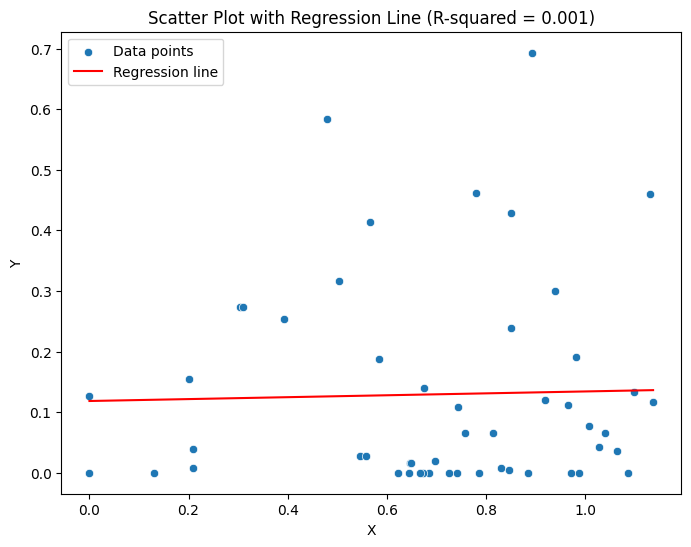

In [ ]:
# Fit a linear regression model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Fit a linear regression model
model = LinearRegression()


## intrinsic properties
# x = merged_data['total_ep']  ##
# x = merged_data['true_hist_ep'] ##
# x = merged_data['true_hist_abvlow_ep'] ##
# x = merged_data['fake_hist_ep']  ##
# x = merged_data['fake_hist_abvlow_ep']  ##
# x = merged_data['abstract_hist_ep']  ##
# x = merged_data['abstract_hist_abvlow_ep']  ##
# x = merged_data['non_hist_ep']  ##
# x = merged_data['non_hist_abvlow_ep'] ##
# x = merged_data['high_quality_ep']
# x = merged_data['above_low_quality_ep']  ##
# x = merged_data['constitudedness']  ##


## extrinsic properties
# x = merged_data['total_ep_integration']  ##
# x = merged_data['total_ep_choice']  ##

# x = merged_data['true_hist_ep_integration']  ##
# x = merged_data['true_hist_ep_choice']  ##

# x = merged_data['true_hist_abvlow_ep_integration']  ##
# x = merged_data['true_hist_abvlow_ep_choice']  ##

# x = merged_data['fake_hist_ep_integration']  ##
# x = merged_data['fake_hist_ep_choice']  ##

# x = merged_data['fake_hist_abvlow_ep_integration']  ##
# x = merged_data['fake_hist_abvlow_ep_choice']  ##

# x = merged_data['abstract_hist_ep_integration']  ##
# x = merged_data['abstract_hist_ep_choice']  ##

# x = merged_data['abstract_hist_abvlow_ep_integration']  ##
# x = merged_data['abstract_hist_abvlow_ep_choice']  ##

# x = merged_data['non_hist_ep_integration']  ##
# x = merged_data['non_hist_ep_choice']  ##

# x = merged_data['non_hist_abvlow_ep_integration']  ##
# x = merged_data['non_hist_abvlow_ep_choice']  ##

# x = merged_data['high_quality_ep_integration']  ##
# x = merged_data['high_quality_ep_choice']  ##

# x = merged_data['above_low_quality_ep_integration']  ##
# x = merged_data['above_low_quality_ep_choice']  ##




# x = merged_data['integration']  ##
# x = merged_data['choice']  ##
# x = merged_data['NAIN']  ##
x = merged_data['NACH']  ##


y = merged_data['check_in']

x = np.array(x)
y = np.array(y)


def log_normalize(array):
    # Min-max normalization
    min_val = array.min()
    max_val = array.max()
    min_max_normalized = (array - min_val) / (max_val - min_val)

    # Adding a small constant epsilon
    epsilon = 1
    adjusted_array = min_max_normalized + epsilon

    # Apply logarithm
    log_normalized_array = np.log(adjusted_array)  # For natural log

    return log_normalized_array

y = log_normalize(y)


model.fit(x.reshape(-1, 1), y)
y_pred = model.predict(x.reshape(-1, 1))

# Calculate R-squared value
r2 = r2_score(y, y_pred)
r2
# Plot the scatter plot with regression line
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, label='Data points')
sns.lineplot(x=x, y=y_pred, color='red', label='Regression line')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Scatter Plot with Regression Line (R-squared = {r2:.3f})')
plt.legend()
plt.show()


## 2 - GLM fitting

In [ ]:
import statsmodels.api as sm

# integrated segments
# all predictors
# X = merged_data[['constitudedness', 'choice', 'integration', 'NACH', 'NAIN',
#                 'total_ep', 'high_quality_ep', 'above_low_quality_ep', 'true_hist_ep',
#                 'fake_hist_ep', 'abstract_hist_ep', 'non_hist_ep',
#                 'true_hist_abvlow_ep', 'fake_hist_abvlow_ep', 'abstract_hist_abvlow_ep',
#                 'non_hist_abvlow_ep', 'total_ep_integration', 'total_ep_choice',
#                 'high_quality_ep_integration', 'high_quality_ep_choice',
#                 'above_low_quality_ep_integration', 'above_low_quality_ep_choice',
#                 'true_hist_ep_integration', 'true_hist_ep_choice',
#                 'fake_hist_ep_integration', 'fake_hist_ep_choice',
#                 'abstract_hist_ep_integration', 'abstract_hist_ep_choice',
#                 'non_hist_ep_integration', 'non_hist_ep_choice',
#                 'true_hist_abvlow_ep_integration', 'true_hist_abvlow_ep_choice',
#                 'fake_hist_abvlow_ep_integration', 'fake_hist_abvlow_ep_choice',
#                 'abstract_hist_abvlow_ep_integration', 'abstract_hist_abvlow_ep_choice',
#                 'non_hist_abvlow_ep_integration', 'non_hist_abvlow_ep_choice'
#                  ]]

## final predictors - VIF<10 & p<0.05
X = merged_data[['constitudedness',
                 'choice',
                 'high_quality_ep',
                 'fake_hist_ep',
                 'non_hist_ep',
                 'true_hist_abvlow_ep_integration',
                ]]

y = merged_data['check_in']


# #### fitting the log-normalized check in below #####
# X = merged_data[['constitudedness', 'integration', 'NACH', 'NAIN',
#                 'total_ep', 'high_quality_ep',
#                 'abstract_hist_ep',
#                 'true_hist_abvlow_ep', 'fake_hist_abvlow_ep', 'abstract_hist_abvlow_ep',
#                 'non_hist_abvlow_ep', 'total_ep_integration',
#                 'high_quality_ep_integration', 'high_quality_ep_choice',
#                 'above_low_quality_ep_integration',
#                 'true_hist_ep_integration', 'true_hist_ep_choice',
#                 'fake_hist_ep_integration',
#                 'abstract_hist_ep_integration', 'abstract_hist_ep_choice',
#                 'non_hist_ep_integration', 'non_hist_ep_choice',
#                 'true_hist_abvlow_ep_integration', 'true_hist_abvlow_ep_choice',
#                 'fake_hist_abvlow_ep_integration', 'fake_hist_abvlow_ep_choice',
#                 'abstract_hist_abvlow_ep_integration', 'abstract_hist_abvlow_ep_choice',
#                 'non_hist_abvlow_ep_integration'
#                  ]]  # all variables are significant adj_R2=0.940


# X = merged_data[['constitudedness',
#                 'abstract_hist_ep',
#                 'true_hist_abvlow_ep','abstract_hist_abvlow_ep',
#                 'non_hist_abvlow_ep',
#                 'high_quality_ep_integration',
#                 'non_hist_ep_choice',
#                 'fake_hist_abvlow_ep_choice',
#                 'abstract_hist_abvlow_ep_choice',
#                 'non_hist_abvlow_ep_integration'
#                  ]]  # all variables are significant adj_R2=0.89


# X = merged_data[['constitudedness',
#                 'true_hist_abvlow_ep',
#                 'non_hist_abvlow_ep',
#                 'high_quality_ep_integration',
#                 'non_hist_abvlow_ep_integration'
#                  ]]  # all variables are significant adj_R2=0.77



                 Generalized Linear Model Regression Results                  
Dep. Variable:               check_in   No. Observations:                   51
Model:                            GLM   Df Residuals:                       45
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -425.81
Date:                Fri, 25 Oct 2024   Deviance:                       662.00
Time:                        05:32:02   Pearson chi2:                     613.
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HC2                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
constitude

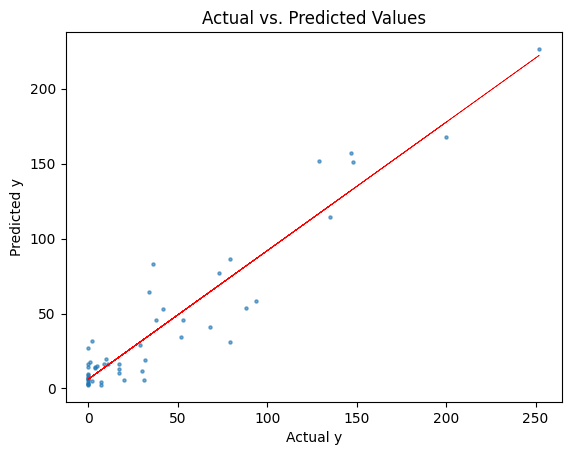

In [ ]:
# Fit a Generalized Linear Model (GLM)
# X = sm.add_constant(X)
model = sm.GLM(y, X, family=sm.families.Poisson())

result = model.fit(cov_type='HC2')

# Display the model summary
print(result.summary())

# Calculate R-squared manually
y_mean = np.mean(y)
SSTotal = np.sum((y - y_mean)**2)
SSResidual = np.sum((y - result.predict(X))**2)
r_squared = 1 - (SSResidual / SSTotal)

# Calculate adjusted R-squared manually
n = len(y)
p = len(result.params) - 1  # Number of predictors + intercept
adjusted_r_squared = 1 - (SSResidual / (n - p - 1)) / (SSTotal / (n - 1))

# Print R-squared and adjusted R-squared
print("R-squared:", r_squared)
print("Adjusted R-squared:", adjusted_r_squared)

# Calculate QIC manually
p = len(result.params)
n = len(y)
deviance = result.deviance
qic = deviance + 2 * p * (p + 1) / (n - p - 1)

# Print QIC value
print("QIC:", qic)


# Calculate VIF for each independent variable
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

# Plot the actual vs. predicted values
y_pred = result.predict(X)

y, y_pred = np.array(y), np.array(y_pred)

# Linear fit for the scatter plot
slope, intercept = np.polyfit(y, y_pred, 1)
line = slope * y + intercept

plt.scatter(y, y_pred, s=5, alpha=0.6)
plt.plot(y, line, label='Best Fit Line', color='red', linewidth=0.5) # Adding the best fit line

plt.xlabel("Actual y")
plt.ylabel("Predicted y")
plt.title("Actual vs. Predicted Values")
plt.savefig("/content/drive/MyDrive/BNWF8/glm.svg", transparent=True)
plt.show()

## 3 - Output merged dataframe for ploting graph in DepthmapX

In [ ]:
# integrated segment plan
merged_data.to_csv('/content/drive/MyDrive/BNWF8/integrated_segment/results/integrated_df_for_depthmap.csv')

# fragmented segment plan
# merged_data.to_csv('/content/drive/MyDrive/BNWF8/fragmented_segment/results/fragmented_df_for_depthmap.csv')